<a href="https://colab.research.google.com/github/efenussmjtk/face-recognition/blob/main/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Check GPU and optimize settings
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"Memory allocated: {torch.cuda.memory_allocated()/1024**2:.1f} MB")
    print(f"Memory reserved: {torch.cuda.memory_reserved()/1024**2:.1f} MB")

    # Enable optimizations
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.enabled = True

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cpu


In [ ]:
# Load data
data_path = '/content/drive/MyDrive/Dataset'  # Adjust path sesuai struktur drive Anda
attr_file = os.path.join(data_path, 'list_attribute.txt')
images_path = os.path.join(data_path, 'Images/')

# Debugging: Check if paths exist
print("Checking dataset paths...")
print(f"Attributes file exists: {os.path.exists(attr_file)}")
print(f"Images folder exists: {os.path.exists(images_path)}")

if os.path.exists(images_path):
    image_files = os.listdir(images_path)
    print(f"Number of image files found: {len(image_files)}")
    print(f"Sample image files: {image_files[:5]}")
else:
    print("Images folder not found! Please check the path.")

Checking dataset paths...
Attributes file exists: True
Images folder exists: True
Number of image files found: 5017
Sample image files: ['086911.jpg', '052853.jpg', '088672.jpg', '127374.jpg', '085390.jpg']


In [ ]:
def load_celeba_attributes(attr_file):
    """Load CelebA attributes file"""
    with open(attr_file, 'r') as f:
        lines = f.readlines()

    # First line: number of images
    num_images = int(lines[0].strip())
    print(f"Total images: {num_images}")

    # Second line: attribute names
    attr_names = lines[1].strip().split()
    print(f"Total attributes: {len(attr_names)}")

    # Parse data
    data = []
    for line in lines[2:]:
        parts = line.strip().split()
        filename = parts[0]
        attributes = [int(x) for x in parts[1:]]
        data.append([filename] + attributes)

    # Create DataFrame
    columns = ['filename'] + attr_names
    df = pd.DataFrame(data, columns=columns)

    # Convert -1 to 0 for binary classification
    for col in attr_names:
        df[col] = df[col].replace(-1, 0)

    return df

In [ ]:
# Load data
print("Loading CelebA attributes...")
df = load_celeba_attributes(attr_file)

Loading CelebA attributes...
Total images: 202599
Total attributes: 40


In [ ]:
# IMPORTANT: Filter dataset to only include images that actually exist
print("\nFiltering dataset to only include existing images...")
if os.path.exists(images_path):
    existing_images = set(os.listdir(images_path))
    print(f"Total images in folder: {len(existing_images)}")

    # Filter dataframe to only include existing images
    original_count = len(df)
    df = df[df['filename'].isin(existing_images)]
    filtered_count = len(df)

    print(f"Original dataset size: {original_count}")
    print(f"Filtered dataset size: {filtered_count}")
    print(f"Missing images: {original_count - filtered_count}")

    if filtered_count == 0:
        print("ERROR: No matching images found! Please check your file paths and folder structure.")
        print("Expected folder structure:")
        print("  /content/drive/MyDrive/")
        print("  ├── list_attribute.txt")
        print("  └── Images/")
        print("      ├── 000001.jpg")
        print("      ├── 000002.jpg")
        print("      └── ...")
    else:
        print(f"Successfully filtered dataset. Using {filtered_count} images for training.")
else:
    print("WARNING: Images folder not found. Using original dataset (will generate dummy images).")


Filtering dataset to only include existing images...
Total images in folder: 5017
Original dataset size: 202599
Filtered dataset size: 5000
Missing images: 197599
Successfully filtered dataset. Using 5000 images for training.


In [ ]:
# Basic info
print(f"Dataset shape: {df.shape}")
print(f"Missing values: {df.isnull().sum().sum()}")

# Gender distribution analysis
gender_dist = df['Male'].value_counts()
print(f"\nGender Distribution:")
print(f"Female (0): {gender_dist[0]} ({gender_dist[0]/len(df)*100:.1f}%)")
print(f"Male (1): {gender_dist[1]} ({gender_dist[1]/len(df)*100:.1f}%)")

Dataset shape: (5000, 41)
Missing values: 0

Gender Distribution:
Female (0): 2953 (59.1%)
Male (1): 2047 (40.9%)


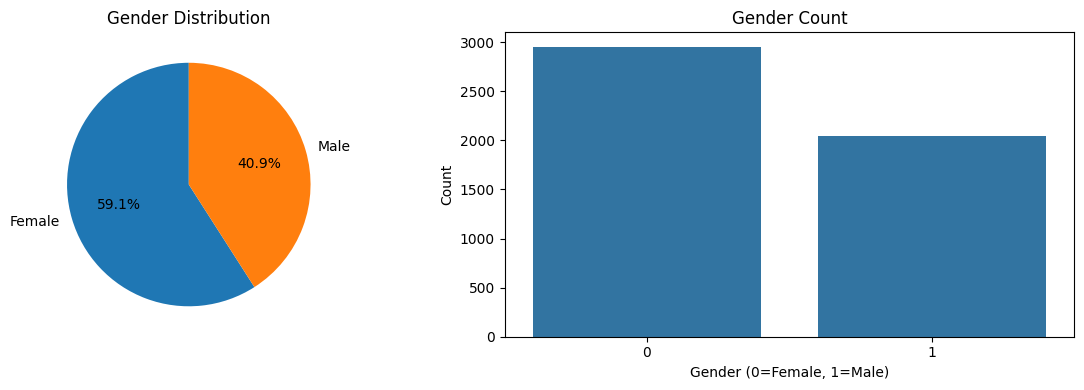

In [ ]:
# Plot gender distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.pie(gender_dist.values, labels=['Female', 'Male'], autopct='%1.1f%%', startangle=90)
plt.title('Gender Distribution')

plt.subplot(1, 2, 2)
sns.countplot(data=df, x='Male')
plt.title('Gender Count')
plt.xlabel('Gender (0=Female, 1=Male)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


Top attributes correlated with gender:
Male                1.000000
Wearing_Lipstick    0.773946
Heavy_Makeup        0.651239
No_Beard            0.519577
5_o_Clock_Shadow    0.415312
Arched_Eyebrows     0.413851
Attractive          0.409725
Big_Nose            0.379700
Wearing_Earrings    0.364263
Wavy_Hair           0.331015
Name: Male, dtype: float64


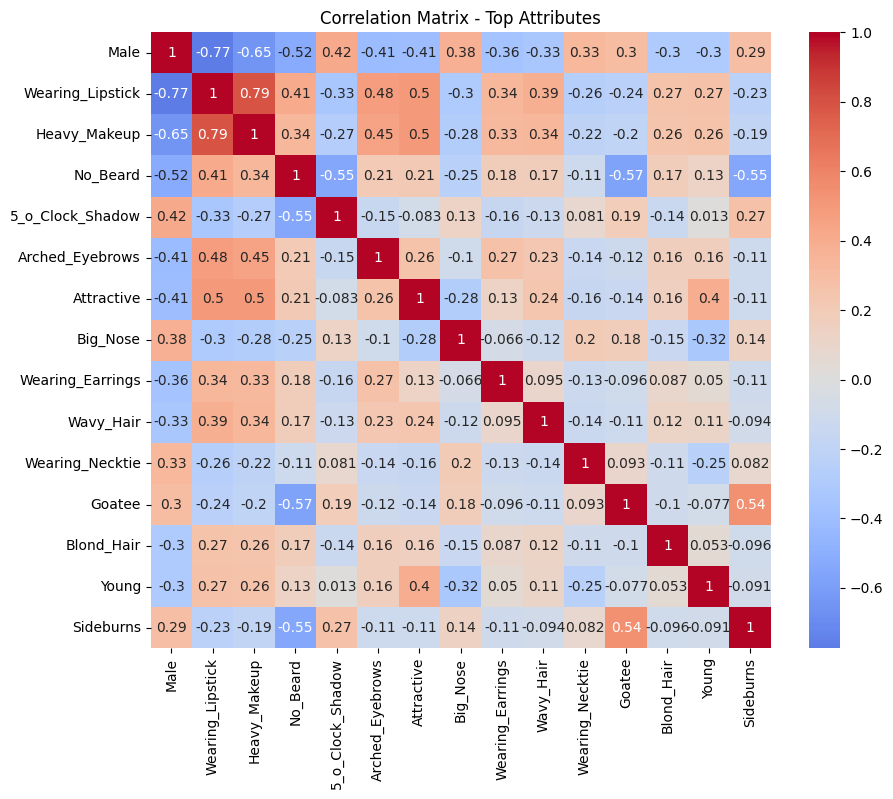

In [ ]:
# Analyze other attributes correlation with gender
print("\nTop attributes correlated with gender:")
# Drop filename column for correlation analysis
numerical_df = df.drop(columns=['filename'])
correlations = numerical_df.corr()['Male'].abs().sort_values(ascending=False)
print(correlations.head(10))

# Plot correlation heatmap for top attributes
top_attrs = correlations.head(15).index.tolist()
plt.figure(figsize=(10, 8))
sns.heatmap(numerical_df[top_attrs].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix - Top Attributes')
plt.show()

In [ ]:
class CelebADataset(Dataset):
    def __init__(self, df, images_path, transform=None):
        self.df = df
        self.images_path = images_path
        self.transform = transform
        self.missing_images = []

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image filename and label
        filename = self.df.iloc[idx]['filename']
        label = self.df.iloc[idx]['Male']  # 0 for female, 1 for male

        # Load image
        img_path = os.path.join(self.images_path, filename)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            # If image not found, create a dummy image
            image = Image.new('RGB', (178, 218), color='gray')
            if filename not in self.missing_images:
                self.missing_images.append(filename)
                # Only print first few warnings to avoid spam
                if len(self.missing_images) <= 10:
                    print(f"Warning: Image {filename} not found - {str(e)}")
                elif len(self.missing_images) == 11:
                    print("... (suppressing further missing image warnings)")

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

In [ ]:
# Define transforms - Simplified for faster processing
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [ ]:
# OPTIMIZATION: Use smaller subset for faster training (optional)
USE_SUBSET = True  # Set to False for full dataset
SUBSET_SIZE = 5000  # Use only 5000 samples for quick testing

if USE_SUBSET and len(df) > SUBSET_SIZE:
    print(f"\nUsing subset of {SUBSET_SIZE} samples for faster training")
    df_subset = df.groupby('Male').apply(
        lambda x: x.sample(min(len(x), SUBSET_SIZE//2), random_state=42)
    ).reset_index(drop=True)
    df = df_subset
    print(f"Subset size: {len(df)}")
    print(f"Gender distribution in subset: {df['Male'].value_counts().values}")

# Split data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['Male'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Male'])

print(f"\nData split:")
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")


Data split:
Training set: 3500 samples
Validation set: 750 samples
Test set: 750 samples


In [ ]:
# Create datasets
train_dataset = CelebADataset(train_df, images_path, train_transform)
val_dataset = CelebADataset(val_df, images_path, val_transform)
test_dataset = CelebADataset(test_df, images_path, val_transform)

# Create data loaders with optimized settings for Colab
batch_size = 64  # Increase batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                         num_workers=0, pin_memory=True, persistent_workers=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                       num_workers=0, pin_memory=True, persistent_workers=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                        num_workers=0, pin_memory=True, persistent_workers=False)

print(f"Batch size: {batch_size}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Batch size: 64
Training batches: 55
Validation batches: 12
Test batches: 12


In [ ]:
class GenderClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super(GenderClassifier, self).__init__()

        # Load pre-trained ResNet50
        self.resnet = models.resnet50(pretrained=True)

        # Freeze early layers (optional - untuk fine-tuning)
        for i, child in enumerate(self.resnet.children()):
            if i < 6:  # Freeze first 6 layers
                for param in child.parameters():
                    param.requires_grad = False

        # Replace the final fully connected layer
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

In [ ]:
# Initialize model
model = GenderClassifier(num_classes=2)
model = model.to(device)

# Print model summary
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

total, trainable = count_parameters(model)
print(f"\nModel Parameters:")
print(f"Total parameters: {total:,}")
print(f"Trainable parameters: {trainable:,}")


Model Parameters:
Total parameters: 24,558,146
Trainable parameters: 23,113,218


In [ ]:
# Loss function with class weights (untuk handle imbalanced data)
class_counts = df['Male'].value_counts().sort_index()
class_weights = torch.tensor([1.0/class_counts[0], 1.0/class_counts[1]], dtype=torch.float).to(device)
class_weights = class_weights / class_weights.sum() * 2  # Normalize

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print(f"Class weights: {class_weights}")

Class weights: tensor([0.8188, 1.1812])


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Progress tracking
    start_time = time.time()

    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        # Print progress every 20 batches instead of 100
        if batch_idx % 20 == 0:
            elapsed = time.time() - start_time
            print(f'Batch {batch_idx}/{len(dataloader)}, Loss: {loss.item():.4f}, '
                  f'Acc: {100.*correct_predictions/total_samples:.1f}%, '
                  f'Time: {elapsed:.1f}s')

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc

In [ ]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct_predictions / total_samples

    return epoch_loss, epoch_acc, all_predictions, all_labels

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    best_val_acc = 0.0
    best_model_state = None

    print("Starting training...")
    print("="*50)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validation phase
        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion, device)

        # Update learning rate
        scheduler.step()

        # Save metrics
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

        # Print epoch results
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Load best model
    model.load_state_dict(best_model_state)
    print(f"\nBest validation accuracy: {best_val_acc:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
num_epochs = 15
print(f"\nStarting training with {num_epochs} epochs...")
train_losses, train_accs, val_losses, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
)


Starting training with 15 epochs...
Starting training...

Epoch 1/15
------------------------------
Batch 0/55, Loss: 0.7250, Acc: 42.2%, Time: 39.5s
Batch 20/55, Loss: 0.1260, Acc: 85.8%, Time: 734.7s
Batch 40/55, Loss: 0.1001, Acc: 89.4%, Time: 1428.1s
Train Loss: 0.2027, Train Acc: 0.9123
Val Loss: 0.1279, Val Acc: 0.9560
Current LR: 0.001000

Epoch 2/15
------------------------------
Batch 0/55, Loss: 0.2238, Acc: 89.1%, Time: 34.3s
Batch 20/55, Loss: 0.0430, Acc: 95.2%, Time: 735.9s
Batch 40/55, Loss: 0.0984, Acc: 96.1%, Time: 1432.1s
Train Loss: 0.0991, Train Acc: 0.9606
Val Loss: 0.1908, Val Acc: 0.9467
Current LR: 0.001000

Epoch 3/15
------------------------------
Batch 0/55, Loss: 0.0735, Acc: 96.9%, Time: 33.7s
Batch 20/55, Loss: 0.0471, Acc: 97.8%, Time: 733.4s
Batch 40/55, Loss: 0.0318, Acc: 97.3%, Time: 1431.8s
Train Loss: 0.0707, Train Acc: 0.9737
Val Loss: 0.0968, Val Acc: 0.9613
Current LR: 0.001000

Epoch 4/15
------------------------------
Batch 0/55, Loss: 0.0308, 

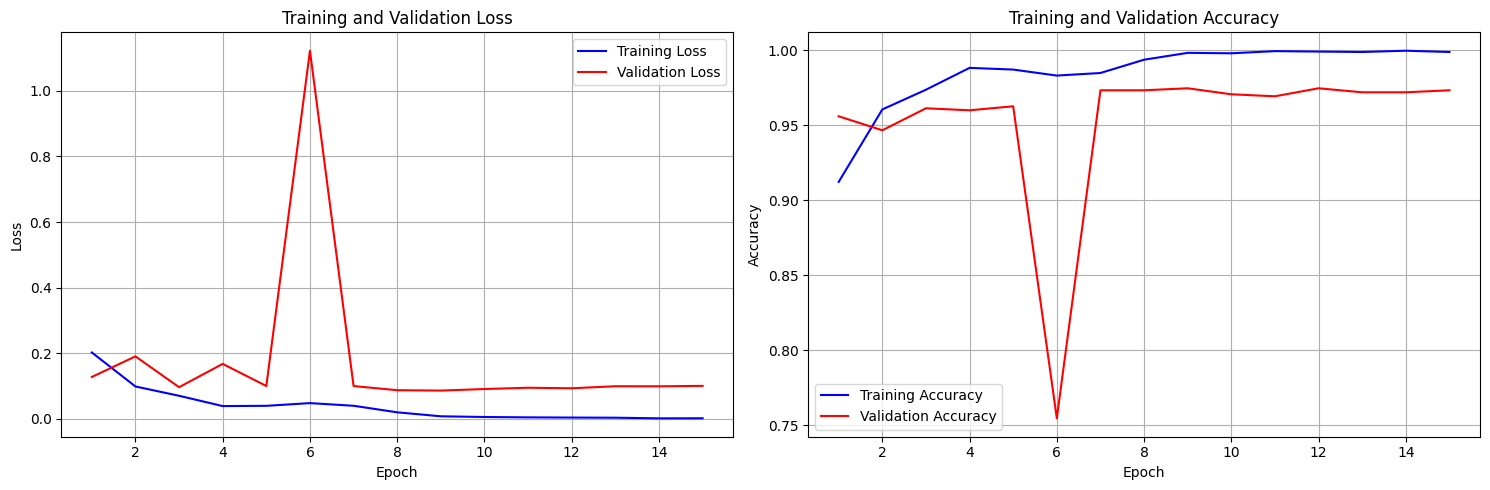

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses)+1), train_losses, 'b-', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accs)+1), train_accs, 'b-', label='Training Accuracy')
plt.plot(range(1, len(val_accs)+1), val_accs, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
test_loss, test_acc, test_predictions, test_labels = validate_epoch(model, test_loader, criterion, device)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_predictions,
                          target_names=['Female', 'Male']))


Test Accuracy: 0.9640
Test Loss: 0.1184

Classification Report:
              precision    recall  f1-score   support

      Female       0.98      0.96      0.97       443
        Male       0.95      0.97      0.96       307

    accuracy                           0.96       750
   macro avg       0.96      0.96      0.96       750
weighted avg       0.96      0.96      0.96       750



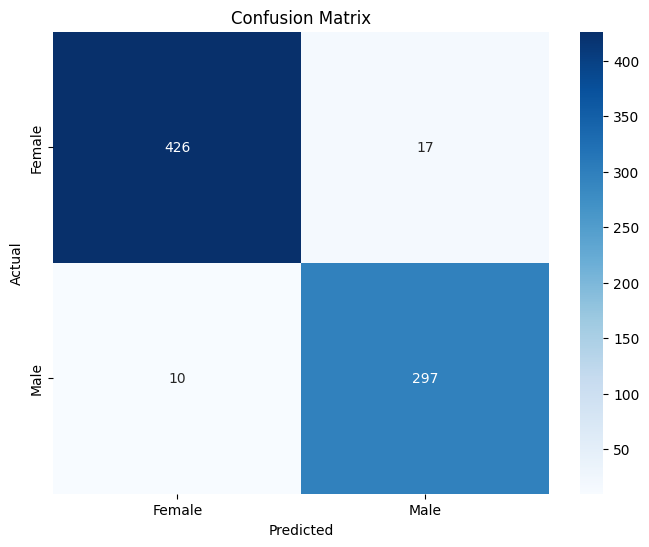

In [ ]:
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def show_sample_predictions(model, dataset, num_samples=8):
    model.eval()

    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = dataset[idx]
            image_batch = image.unsqueeze(0).to(device)

            # Get prediction
            output = model(image_batch)
            _, predicted = torch.max(output, 1)
            predicted_label = predicted.item()

            # Get prediction probability
            probs = torch.softmax(output, dim=1)
            confidence = probs[0][predicted_label].item()

            # Denormalize image for display
            image_display = image.clone()
            mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
            image_display = image_display * std + mean
            image_display = torch.clamp(image_display, 0, 1)

            # Convert to numpy and transpose
            img_np = image_display.permute(1, 2, 0).numpy()

            # Plot
            axes[i].imshow(img_np)
            axes[i].axis('off')

            true_gender = 'Male' if true_label == 1 else 'Female'
            pred_gender = 'Male' if predicted_label == 1 else 'Female'

            color = 'green' if true_label == predicted_label else 'red'
            title = f'True: {true_gender}\nPred: {pred_gender} ({confidence:.2f})'
            axes[i].set_title(title, color=color, fontsize=10)

    plt.tight_layout()
    plt.show()



Sample Predictions:


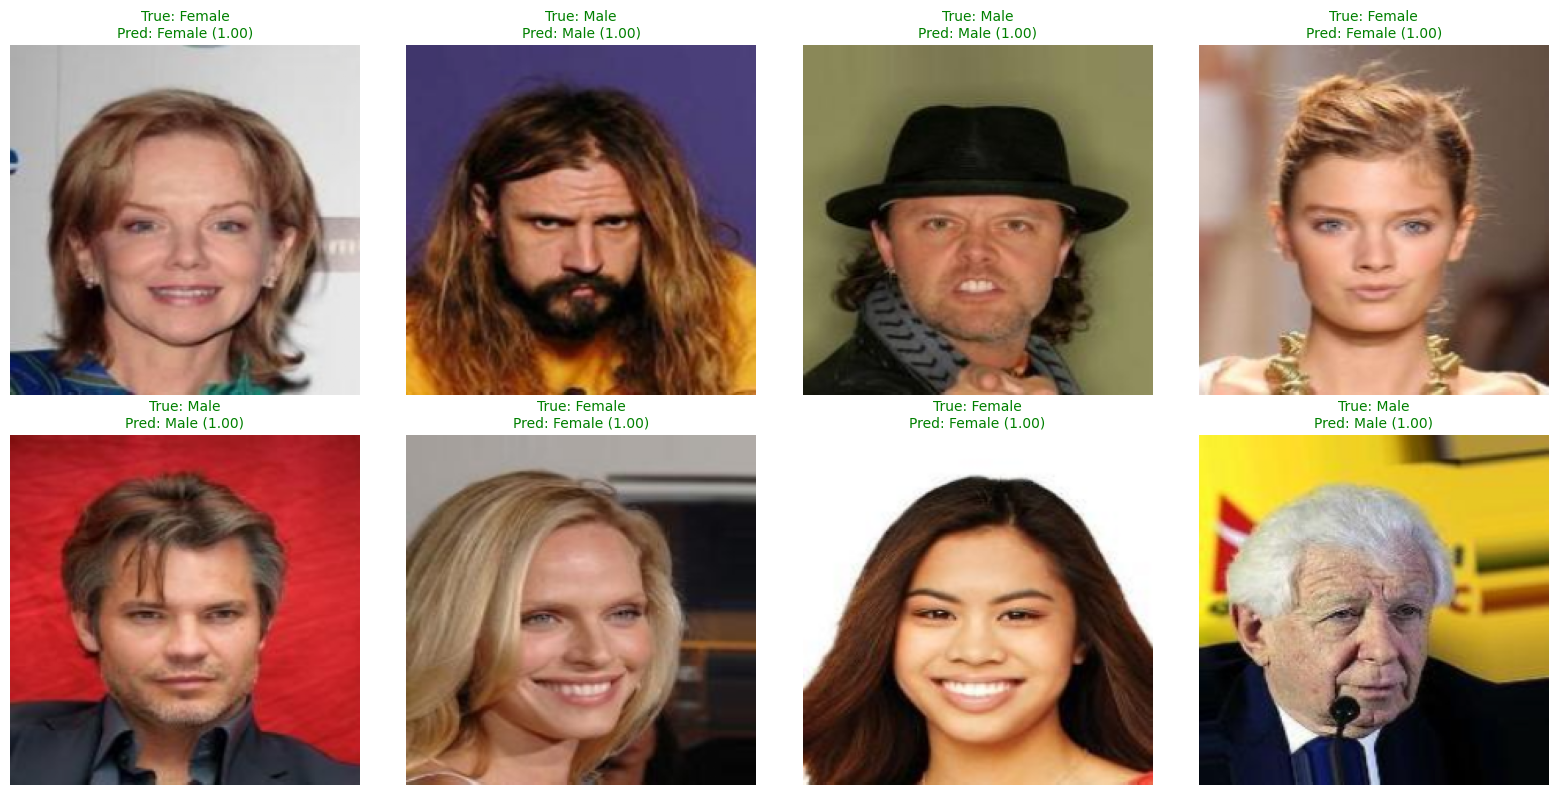

In [ ]:
print("\nSample Predictions:")
show_sample_predictions(model, test_dataset, num_samples=8)


Upload an image for classification:


Saving download (1).jpeg to download (1) (1).jpeg
User uploaded file "download (1) (1).jpeg"


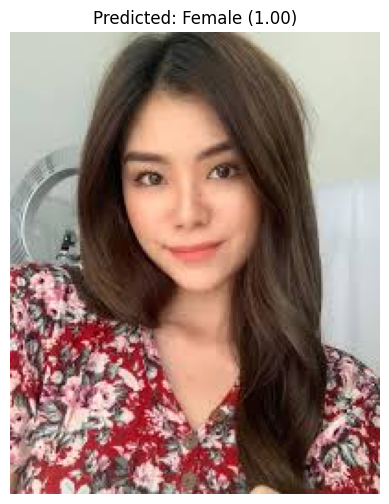

Classification Result for 'download (1) (1).jpeg':
  Predicted Gender: Female
  Confidence: 0.9994


In [ ]:
from google.colab import files
from PIL import Image
import io
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Function to classify a single uploaded image
def classify_uploaded_image(model, device, transform):
    uploaded = files.upload()

    if not uploaded:
        print("No file uploaded.")
        return

    for filename in uploaded.keys():
        print(f'User uploaded file "{filename}"')

        try:
            # Read image from bytes
            img = Image.open(io.BytesIO(uploaded[filename])).convert('RGB')

            # Apply transformation
            input_tensor = transform(img)
            input_batch = input_tensor.unsqueeze(0).to(device)  # Add a batch dimension

            # Perform inference
            model.eval()
            with torch.no_grad():
                output = model(input_batch)

            # Get predicted class and confidence
            probs = torch.softmax(output, dim=1)
            _, predicted_class = torch.max(probs, 1)

            # Map class index to gender label
            # Assuming 0 is Female and 1 is Male based on your dataset analysis
            class_labels = ['Female', 'Male']
            predicted_gender = class_labels[predicted_class.item()]
            confidence = probs[0][predicted_class.item()].item()

            # Display image and prediction
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f'Predicted: {predicted_gender} ({confidence:.2f})')
            plt.axis('off')
            plt.show()

            print(f"Classification Result for '{filename}':")
            print(f"  Predicted Gender: {predicted_gender}")
            print(f"  Confidence: {confidence:.4f}")

        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Define the transformation for inference (same as validation transform)
inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Ensure the model is on the correct device
model.to(device)

# Call the function to allow user to upload and classify
print("\nUpload an image for classification:")
classify_uploaded_image(model, device, inference_transform)